In [1]:
import wfdb
import pywt
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
from scipy.signal import resample_poly
from scipy import stats
import scipy
import seaborn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler  
#from process import processingData

In [2]:
category = ['normal', 'abnormal']
destination = 'D:/学习/毕业设计/data/'
# 数据库的原始频率
fs_afdb = 250
fs_nsrdb = 128
left_len = 1
right_len = 2  # 数据左取1s 右取2s

In [3]:
# 低通滤波去除高频噪音
def filtering(data, record):
    # 设置滤波器参数
    nyquist_freq = 0.5 * record.fs
    cutoff_freq = 35  # 设置截止频率为35Hz
    filter_order = 4  # 设置滤波器阶数为4

    # 计算滤波器系数
    b, a = butter(filter_order, cutoff_freq / nyquist_freq, btype='low')

    # 对信号进行滤波
    data_filtered = lfilter(b, a, data)

    # 打印原始信号和滤波后的信号的长度
    # print('Original signal length:', len(data), 'samples')
    # print('Filtered signal length:', len(data_filtered), 'samples')
    return data_filtered

In [4]:
# 小波阈值去噪函数
def wavelet_denoising(data):
    # 小波分解
    coeffs = pywt.wavedec(data, 'db4', level=4)
    # 小波重构
    denoised_data = pywt.waverec(coeffs, 'db4')
    return denoised_data


In [5]:
# 正常数据和房颤数据处理不一样
def getDataSet_abnormal(number, X_data, Y_data, flag):
    # 读取心电数据记录
    print(flag, "正在读取 ,", number, " 号心电数据...")
    record = wfdb.rdrecord(destination + category[flag] + '/' + number, channel_names=['ECG1'])
    data = record.p_signal.flatten()
    data1 = filtering(data, record)  # 低通滤波
    data2 = wavelet_denoising(data=data1)  # 小波变换
    # data3 = resample(data2, record)
    res_data = stats.zscore(data2)

    # 获取心电数据记录中R波的位置和对应的标签
    annotation = wfdb.rdann(destination + category[flag] + '/' + number, 'atr')
    Rlocation = annotation.sample

    # 获取标记符号列表
    symbol_list = annotation.aux_note

    # 查找所有包含N标记的注释区间
    N_ranges = []
    N_start = None
    for i, symbol in enumerate(symbol_list):
        if symbol == '(N' and N_start is None:
            N_start = Rlocation[i]
        elif symbol != '(N' and N_start is not None:
            N_end = Rlocation[i]
            N_ranges.append((N_start, N_end))
            N_start = None

    # 如果最后一个注释是N，需要手动添加其结束位置
    if N_start is not None:
        N_end = len(res_data)
        N_ranges.append((N_start, N_end))

    # 输出找到的N区间的数量
    # print('Found %d N segments.' % len(N_ranges))

    # 从正常位置中找到R峰
    for start, end in N_ranges:
        x_ann = wfdb.rdann(destination + category[flag] + '/' + number, 'qrs', sampfrom=start, sampto=end)
        Rlocation_N = x_ann.sample
        i = 5
        j = len(Rlocation_N) - 10
        while i < j:
            try:
                tmp_data = res_data[Rlocation_N[i] - left_len * fs_afdb:Rlocation_N[i] + right_len * fs_afdb]
                # 需要对房颤数据集进行下采样
                re_signal = scipy.signal.resample(tmp_data, 384)  # 采样
                X_data.append(re_signal)
                Y_data.append(flag)
                i += 3  # 间隔三个周期提取一个波形
            except ValueError:
                i += 3
    return

In [6]:
# 读取心电数据和对应标签,并对数据进行小波去噪
# 传入对应的文件名，以及标注
def getDataSet_normal(number, X_data, Y_data, flag):
    # 读取心电数据记录
    print(flag, "正在读取 ,", number, " 号心电数据...")
    record = wfdb.rdrecord(destination + category[flag] + '/' + number, channel_names=['ECG1'])
    data = record.p_signal.flatten()
    data1 = filtering(data, record)  # 低通滤波
    data2 = wavelet_denoising(data=data1)  # 小波变换
    res_data = stats.zscore(data2)

    # 获取心电数据记录中R波的位置和对应的标签
    annotation = wfdb.rdann(destination + category[flag] + '/' + number, 'atr')
    Rlocation = annotation.sample

    # 去掉前后的不稳定数据
    i = 10
    j = len(annotation.symbol) - 5

    # 正常心跳截取R峰左右，按照经验左边取100点，右边取200点
    while i < j:
        try:
            x_train = res_data[Rlocation[i] - left_len * fs_nsrdb:Rlocation[i] + right_len * fs_nsrdb]
            X_data.append(x_train)
            Y_data.append(flag)
            i += 3
        except ValueError:
            i += 3
    return

In [7]:
def loadData(root_folder, normal_data, abnormal_data):
    for cat in category:
        folder_name = []
        for filename in os.listdir(root_folder + cat):
            # 读取目录下的所有文件
            if filename[0:5] in folder_name:  # 判断文件名的前五个字符
                continue
            else:
                folder_name.append(filename[0:5])
        for name in folder_name:
            if name[0] not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']:  # 跳过无用的文件
                continue
            elif name in ['00735', '03665']:  # 跳过不可用文件
                continue
            if cat == 'normal':
                normal_data.append(name)
            elif cat == 'abnormal':
                abnormal_data.append(name)

In [8]:
# 加载数据集并进行预处理
def processingData():
    # all
    normal_all = ['16265', '16272', '16273', '16420', '16483', '16539', '16773', '16786', '16795', '17052', '17453',
                  '18177', '18184', '19088', '19090', '19093', '19140', '19830']
    # 正常测试集
    normal_set_test = ['19090','16483','19830','19093']
    # 正常训练集
    normal_set_train = []
    for i in normal_all:
        if i not in normal_set_test:
            normal_set_train.append(i)

    abnormal_all = ['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426',
                    '06453', '06995', '07162', '07859', '07879', '07910', '08215', '08219', '08378', '08405', '08434',
                    '08455']
    # 不正常测试集
    abnormal_set_test = ['04015','07859','07162','04048']
    # 不正常训练集
    abnormal_set_train = []
    for j in abnormal_all:
        if j not in abnormal_set_test:
            abnormal_set_train.append(j)

    dataSet_train = []
    dataSet_test = []
    labelSet_train = []
    labelSet_test = []

    # 处理测试集
    for m in normal_set_test:
        getDataSet_normal(m, dataSet_test, labelSet_test, 0)
    for m in abnormal_set_test:
        getDataSet_abnormal(m, dataSet_test, labelSet_test, 1)

    # 测试集 打乱
    dataSet_test = np.array(dataSet_test).reshape(-1, 384)
    labelSet_test = np.array(labelSet_test).reshape(-1, 1)
    test_ds = np.hstack((dataSet_test, labelSet_test))
    np.random.seed(42)
    np.random.shuffle(test_ds)

    # 数据集及其标签集
    X_test = test_ds[:, :384].reshape(-1, 384, 1)
    Y_test = test_ds[:, 384]

    return X_test, Y_test


In [9]:
X,Y=processingData()
print(X.shape)
print(Y.shape)

0 正在读取 , 19090  号心电数据...
0 正在读取 , 16483  号心电数据...
0 正在读取 , 19830  号心电数据...
0 正在读取 , 19093  号心电数据...
1 正在读取 , 04015  号心电数据...
1 正在读取 , 07859  号心电数据...
1 正在读取 , 07162  号心电数据...
1 正在读取 , 04048  号心电数据...
(154586, 384, 1)
(154586,)


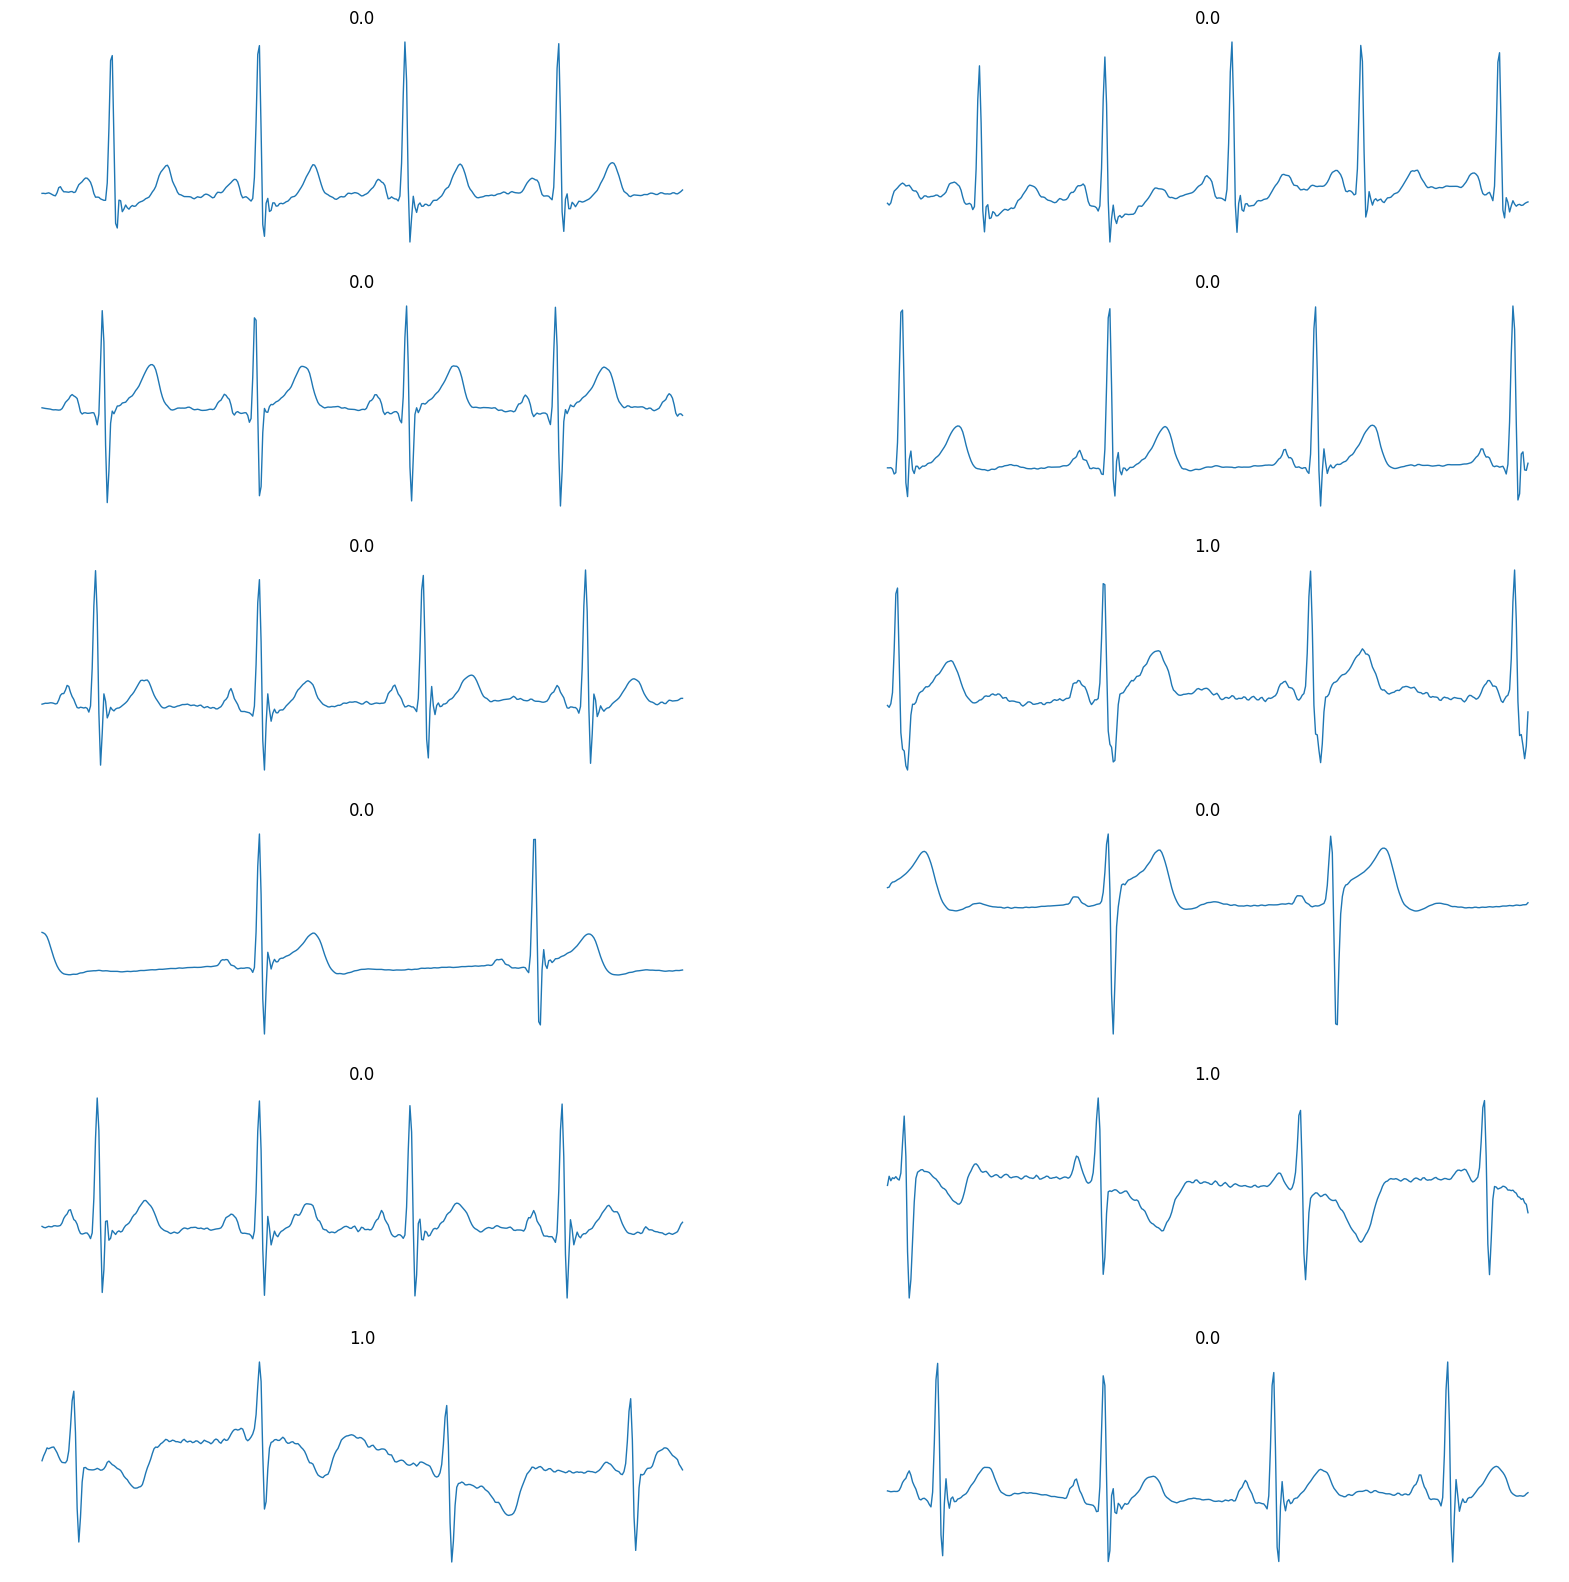

In [12]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (0.1,0.1)
plt.figure()
for index in range(1,13):
    plt.subplot(6,2,index)
    plt.plot(X[index], linewidth=1)  
    # plt.yticks(np.arange(np.min(ecg[:,index]), np.max(ecg[:,index]), 0.1))
    plt.gca()
    plt.title(Y[index])
    plt.axis('off')
plt.show()

In [14]:
X_resampled, y_resampled = RandomUnderSampler().fit_resample(X, Y)
Y_d2=pd.DataFrame(y_resampled)
print(Y_d2.value_counts())

0.0    417315
1.0    417315
dtype: int64
